# Transfer learning with tensorflow Part 3: Scaling up (🍔👁 Food Vision Mini) 

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning)

Original Food101 paper : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different taks let's download them.

In [1]:
!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


Saved under helper_functions (1).py


In [26]:
# Import series of helper functions for notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
%matplotlib inline

## 101 Food classes working with less data

Our goal is to beat the original Food101 paper with 10% of trianing data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_notification_notebook

In [4]:
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip


Saved under 101_food_classes_10_percent.zip


In [5]:
unzip_data('101_food_classes_10_percent.zip')

In [1]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [3]:
# How many images classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [5]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                       label_mode = 'categorical',
                                                                       image_size = IMG_SIZE)

test_data_all_10_percent = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                       label_mode = 'categorical',
                                                                       image_size = IMG_SIZE,
                                                                      shuffle = False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a model checkpoint callback.
* Create a data augmentation layer to build data augmentation right into the model.
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer).
* Compile our model.
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% on test data to save epoch time).

In [6]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor='val_accuracy',
                                                        save_best_only = True)

In [10]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentation

data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    #layers.Rescaling(1/255.) rescale inputs inputs of images between 0 & 1, required for models like ResNet50
], name='data_augmentation')

In [13]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3 ), name='input_layer')
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode, so weights which need to stay frozen, stay frozen.
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [22]:
# compile the model
model.compile(loss = 'categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

# Fit 
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs = 5, #fit for 5 epochs to keep experiments quick
                                          validation_data = test_data_all_10_percent,
                                          validation_steps = int(0.15 * len(test_data_all_10_percent)),# validate on only 15% of train data while train
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 125s 488ms/step - loss: 3.4714 - accuracy: 0.2458 - val_loss: 2.7291 - val_accuracy: 0.3766
Epoch 2/5
237/237 [==============================] - 97s 407ms/step - loss: 2.3524 - accuracy: 0.4606 - val_loss: 2.2720 - val_accuracy: 0.4547
Epoch 3/5
237/237 [==============================] - 91s 384ms/step - loss: 1.9846 - accuracy: 0.5335 - val_loss: 2.1496 - val_accuracy: 0.4595
Epoch 4/5
237/237 [==============================] - 82s 345ms/step - loss: 1.7692 - accuracy: 0.5699 - val_loss: 2.0365 - val_accuracy: 0.4778
Epoch 5/5
237/237 [==============================] - 83s 351ms/step - loss: 1.6052 - accuracy: 0.6078 - val_loss: 1.9774 - val_accuracy: 0.4915


In [24]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data_all_10_percent)
feature_extraction_results

790/790 [==============================] - 124s 157ms/step - loss: 1.7279 - accuracy: 0.5491


[1.7278920412063599, 0.5491089224815369]

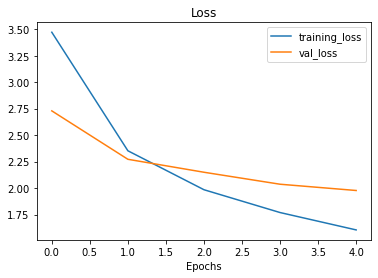

In [27]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest?
Hint: Ideally the two curves should be very similar, if not it may suggest that our model is overfitting (performing too weel on the training data and not generalizing on unseen data)

## Fine-tuning


In [28]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [33]:
# Recompile our model with lower training rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss = 'categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(1e-4), # learning rate lowered by 10X
             metrics = ['accuracy'])

In [35]:
# What layers in the model are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [37]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [44]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # The model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5)

# Fine-tune our model
history_all_classes_10_percent_fine_tune =  model.fit(train_data_all_10_percent,
                                                      epochs = fine_tune_epochs,
                                                      validation_data = test_data_all_10_percent,
                                                      validation_steps = int(0.15 * len(test_data_all_10_percent)),
                                                      initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 86s 338ms/step - loss: 1.3608 - accuracy: 0.6512 - val_loss: 1.9787 - val_accuracy: 0.4968
Epoch 6/10
237/237 [==============================] - 74s 310ms/step - loss: 1.2220 - accuracy: 0.6780 - val_loss: 1.9958 - val_accuracy: 0.4974
Epoch 7/10
237/237 [==============================] - 76s 318ms/step - loss: 1.1588 - accuracy: 0.6943 - val_loss: 1.9917 - val_accuracy: 0.4992
Epoch 8/10
237/237 [==============================] - 72s 304ms/step - loss: 1.0920 - accuracy: 0.7150 - val_loss: 1.9419 - val_accuracy: 0.5162
Epoch 9/10
237/237 [==============================] - 72s 302ms/step - loss: 1.0115 - accuracy: 0.7365 - val_loss: 1.9428 - val_accuracy: 0.5177
Epoch 10/10
237/237 [==============================] - 71s 300ms/step - loss: 0.9670 - accuracy: 0.7439 - val_loss: 1.9454 - val_accuracy: 0.5162


In [45]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data_all_10_percent)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 122s 154ms/step - loss: 1.6268 - accuracy: 0.5766


[1.6267633438110352, 0.5766336917877197]

In [48]:
# Compare histories of feature_extraction model with fine-tuning model
compare_historys(history_all_classes_10_percent,
                history_all_classes_10_percent_fine_tune,
                initial_epochs = 5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [49]:
# Save our fine-tuning model
model.save('101_food_classes_10_percent_save_big_model')

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_save_big_model\assets


D:\Anaconda3\envs\TensorflowTut\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [50]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model('./101_food_classes_10_percent_save_big_model/')

In [52]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

790/790 [==============================] - 130s 162ms/step - loss: 1.6268 - accuracy: 0.5766


[1.6267633438110352, 0.5766336917877197]

In [53]:
# The results from our loaded model above should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.6267633438110352, 0.5766336917877197]

## Evaluating the performance of the big model across all different classes

Let's make some predictions, visualize them and then later find out which predictings we're "most" wrong

In [56]:
import tensorflow as tf

# Downlaod pretrained model (one that was pretrained earlier, so all predictions are similar)
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


Saved under 06_101_food_class_10_percent_saved_big_dog_model.zip


In [57]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [58]:
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [60]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data_all_10_percent)
results_downloaded_model

790/790 [==============================] - 129s 161ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [62]:
# Make predictions with model
preds_prob = model.predict(test_data_all_10_percent, verbose = 1,) # Set verbosity to see how long is left

790/790 [==============================] - 112s 141ms/step


In [63]:
# How many predictions are there?
len(preds_prob)

25250

In [64]:
# What's the shape of our predictions
preds_prob.shape

(25250, 101)

In [66]:
# Let's see what the first 10 predictions look like
preds_prob[:10]

array([[5.9542116e-02, 3.5742148e-06, 4.1376818e-02, ..., 1.4138627e-09,
        8.3530584e-05, 3.0897425e-03],
       [9.6401680e-01, 1.3753194e-09, 8.4780209e-04, ..., 5.4286887e-05,
        7.8362065e-12, 9.8465835e-10],
       [9.5925879e-01, 3.2533651e-05, 1.4866921e-03, ..., 7.1891071e-07,
        5.4397321e-07, 4.0275892e-05],
       ...,
       [4.7313160e-01, 1.2931218e-07, 1.4805639e-03, ..., 5.9750059e-04,
        6.6969274e-05, 2.3469336e-05],
       [4.4571873e-02, 4.7265340e-07, 1.2258477e-01, ..., 6.3498319e-06,
        7.5318289e-06, 3.6778674e-03],
       [7.2438955e-01, 1.9249879e-09, 5.2311334e-05, ..., 1.2291436e-03,
        1.5792774e-09, 9.6395932e-05]], dtype=float32)

In [73]:
# What does the first prediction probability array look like?
preds_prob[0], len(preds_prob[0]), sum(preds_prob[0])

(array([5.95421158e-02, 3.57421482e-06, 4.13768180e-02, 1.06605147e-09,
        8.16142798e-09, 8.66396554e-09, 8.09268158e-07, 8.56521638e-07,
        1.98590151e-05, 8.09774519e-07, 3.17276228e-09, 9.86734563e-07,
        2.85322167e-04, 7.80487452e-10, 7.42300879e-04, 3.89162633e-05,
        6.47403112e-06, 2.49771847e-06, 3.78910954e-05, 2.06782289e-07,
        1.55383914e-05, 8.15069370e-07, 2.62304934e-06, 2.00106271e-07,
        8.38274502e-07, 5.42155658e-06, 3.73910711e-06, 1.31504825e-08,
        2.77614850e-03, 2.80519198e-05, 6.85618951e-10, 2.55747836e-05,
        1.66889280e-04, 7.64069974e-10, 4.04527585e-04, 1.31506841e-08,
        1.79573431e-06, 1.44481601e-06, 2.30628997e-02, 8.24667779e-07,
        8.53651159e-07, 1.71385466e-06, 7.05249613e-06, 1.84021669e-08,
        2.85533474e-07, 7.94832249e-06, 2.06814343e-06, 1.85252404e-07,
        3.36196422e-08, 3.15224606e-04, 1.04109531e-05, 8.54480390e-07,
        8.47418606e-01, 1.05554345e-05, 4.40947531e-07, 3.740403

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method

In [76]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f'Number of prediction probabilities for sample 0:{len(preds_prob[0])}')
print(f'What prediction probability sample 0 looks like:{preds_prob[0]}')
print(f'The class with the highest predicted probability by the model for sample 0: {preds_prob[0].argmax()}')

Number of prediction probabilities for sample 0:101
What prediction probability sample 0 looks like:[5.95421158e-02 3.57421482e-06 4.13768180e-02 1.06605147e-09
 8.16142798e-09 8.66396554e-09 8.09268158e-07 8.56521638e-07
 1.98590151e-05 8.09774519e-07 3.17276228e-09 9.86734563e-07
 2.85322167e-04 7.80487452e-10 7.42300879e-04 3.89162633e-05
 6.47403112e-06 2.49771847e-06 3.78910954e-05 2.06782289e-07
 1.55383914e-05 8.15069370e-07 2.62304934e-06 2.00106271e-07
 8.38274502e-07 5.42155658e-06 3.73910711e-06 1.31504825e-08
 2.77614850e-03 2.80519198e-05 6.85618951e-10 2.55747836e-05
 1.66889280e-04 7.64069974e-10 4.04527585e-04 1.31506841e-08
 1.79573431e-06 1.44481601e-06 2.30628997e-02 8.24667779e-07
 8.53651159e-07 1.71385466e-06 7.05249613e-06 1.84021669e-08
 2.85533474e-07 7.94832249e-06 2.06814343e-06 1.85252404e-07
 3.36196422e-08 3.15224606e-04 1.04109531e-05 8.54480390e-07
 8.47418606e-01 1.05554345e-05 4.40947531e-07 3.74040355e-05
 3.53061259e-05 3.24889152e-05 6.73144168e-05 

In [77]:
test_data_all_10_percent.class_names[52]

'gyoza'

In [78]:
# Get the pred classes for each label
pred_classes = preds_prob.argmax(axis = 1)

# How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [79]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels. 

In [83]:
# to get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data_all_10_percent.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like (0, 0, 0, 1..., 0 ,0) we want the index value where the "1 occurs"
y_labels[:10] # look at first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [84]:
# how many y_labels are there?
len(y_labels)

25250

## Evaluating our model's prediction

One way to check that our model's predictions array is in the same order as our test labels array is to find accuracy score. 

In [86]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [90]:
# Let's try scikit-learn accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [92]:
# Does this metrics are close tou our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [94]:
from helper_functions import make_confusion_matrix

In [93]:
class_names = test_data_all_10_percent.class_names

In [103]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    ### Chaged (plot x-labels vertically) ###
    plt.xticks(rotation=70, fontsize = text_size)
    plt.yticks(fontsize= text_size)
    
    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
            
      # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [106]:
make_confusion_matrix(y_true = y_labels,
                     y_pred = pred_classes,
                     classes = class_names,
                     figsize=(100,100),
                     text_size = 20,
                     savefig = True)

## Let's keep the evaluation train goign time for classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. preciison, recall and F1) called classification_report

In [108]:
from sklearn.metrics import classification_report

In [110]:
print(classification_report(y_true = y_labels,
                           y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get better understanding

In [112]:
# Get a dictonary of classification report 
classification_report_dict = classification_report(y_true = y_labels,
                                                   y_pred = pred_classes,
                                                  output_dict = True)

Let's plot all of our classes F1-scores...

In [114]:
# Create empty dictonary 
class_f1_scores = {}
# Loop through classification report dictonary items
for k, v in classification_report_dict.items():
    if k == 'accuracy': # stop once we get to accuracy key
        break
    else: 
        # Add class names and f1-scores to new dictonary
        class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [120]:
# Turn f1-scores into dataframes for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                         'f1-scores':list(class_f1_scores.values())}).sort_values('f1-scores', ascending = False)

In [121]:
f1_scores

class_names  f1-scores
33              edamame   0.937143
63             macarons   0.895397
75                  pho   0.866538
91  spaghetti_carbonara   0.847656
69              oysters   0.834008
..                  ...        ...
56     huevos_rancheros   0.339833
22     chocolate_mousse   0.329159
77            pork_chop   0.308756
39            foie_gras   0.297491
0             apple_pie   0.240566

[101 rows x 2 columns]

In [144]:
fig, ax = plt.subplots(figsize = (12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-scores'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 Different Food Classes (predicted by Food Vision Mini)')
ax.invert_yaxis()
plt.tight_layout(); # Reverse the order of our plot

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        width = rect.get_width()
        ax.text((rect.get_x()+width)+0.02, rect.get_y()+(height),
                s = f'{width:.2f}',
                ha='center', va='bottom')
        
autolabel(scores)

🛠 **Exercise**: Try visualizing some of the most poorly predicted classes (e.g. `apple_pie`, `pork_chop`), do you notice any trends among them? Why might our model be having trouble with them?

## Visualizing prediction on test images

Now, this is the real test how does our model goes on food images not even in our dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load an preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decado_image()
* Resize the image tensor to be the same size as the iamges our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values betwen 0 & 1 (if necessary)

In [149]:
# Create a function to load an prepare iamges
def load_and_prep_images(filename, img_shape= 224, scale = True):
    '''
    Read in a image from filename, turns it inot a tensor and reshapes into a 
    specified shape (img_shape, img_shape, color_channels=3)
    
    Args:
        filename(str): path to taget image
        image_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not
        
    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    '''
    # Read in the image
    img = tf.io.read_file(filename)
    
    # Decode image into tensor
    img = tf.io.decode_image(img, channels = 3)
    
    # Resize the image
    img = tf.image.resize(img, size = [img_shape, img_shape])
    
    # Scale
    if scale:
        # rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img # don't need to rescale images for EfficientNet models in TensorFlow

Now we've got a function to load and prepare target iamges, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the laoded images
3. Plot the original image(s) along with the model's prediction, prediction probability and truth label

In [171]:
# Make preds on a series of random images
import os
import random 

plt.figure(figsize = (17, 10))
for i in range(3):
    # Choose a random image(s) from a random class(es)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + '/' + class_name))
    filepath = test_dir + class_name + '/' + filename
    
    # Load the iamge and make predictions
    img = load_and_prep_images(filepath, scale = False)
    img_expanded = tf.expand_dims(img, axis = 0)
    pred_prob = model.predict(img_expanded) # Get prediction prob array
    pred_class = class_names[pred_prob.argmax()] # Get highest prediction prob index
    
    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # if pred class matches truth class, make text green
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f' actual: {class_name}, pred: {pred_class} \n prob: {pred_prob.max():.2f}', c = title_color)
    plt.axis(False);

## Finding the most wrong predictions

To find out where model is most wrong, let's write some code to find out the following:
1. Get all the image file paths in the test dataset using *list_files()* method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilties, prediction class names and ground truth.
3. Use our DataFrame to find all the wrong predictions (where ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have highest prediciton prob at the top)
5. Visualize the images with the highest prediction probabilites but have wrong prediction.

In [173]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data_all_10_percent.list_files('./101_food_classes_10_percent/test/*/*.jpg',
                                                    shuffle = False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'.\\101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'.\\101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [174]:
# 2. Create a DF of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                       'y_true': y_labels,
                       'y_pred': pred_classes,
                       'pred_conf': preds_prob.max(axis=1),
                       'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]
                       })

In [175]:
pred_df

img_path  ...      y_pred_classname
0      b'.\\101_food_classes_10_percent\\test\\apple_...  ...                 gyoza
1      b'.\\101_food_classes_10_percent\\test\\apple_...  ...             apple_pie
2      b'.\\101_food_classes_10_percent\\test\\apple_...  ...             apple_pie
3      b'.\\101_food_classes_10_percent\\test\\apple_...  ...  pulled_pork_sandwich
4      b'.\\101_food_classes_10_percent\\test\\apple_...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'.\\101_food_classes_10_percent\\test\\waffle...  ...               waffles
25246  b'.\\101_food_classes_10_percent\\test\\waffle...  ...          cheese_plate
25247  b'.\\101_food_classes_10_percent\\test\\waffle...  ...               waffles
25248  b'.\\101_food_classes_10_percent\\test\\waffle...  ...  strawberry_shortcake
25249  b'.\\101_food_classes_10_percent\\test\\waffle...  ...               waffles

[25250 rows x 6 columns]

In [176]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  ...  pred_correct
0  b'.\\101_food_classes_10_percent\\test\\apple_...  ...         False
1  b'.\\101_food_classes_10_percent\\test\\apple_...  ...          True
2  b'.\\101_food_classes_10_percent\\test\\apple_...  ...          True
3  b'.\\101_food_classes_10_percent\\test\\apple_...  ...         False
4  b'.\\101_food_classes_10_percent\\test\\apple_...  ...         False

[5 rows x 7 columns]

In [178]:
# 4. Sort our dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending = False)[:100]
top_100_wrong.head()

img_path  ...  pred_correct
21810  b'.\\101_food_classes_10_percent\\test\\scallo...  ...         False
231    b'.\\101_food_classes_10_percent\\test\\apple_...  ...         False
15359  b'.\\101_food_classes_10_percent\\test\\lobste...  ...         False
23539  b'.\\101_food_classes_10_percent\\test\\strawb...  ...         False
21400  b'.\\101_food_classes_10_percent\\test\\samosa...  ...         False

[5 rows x 7 columns]

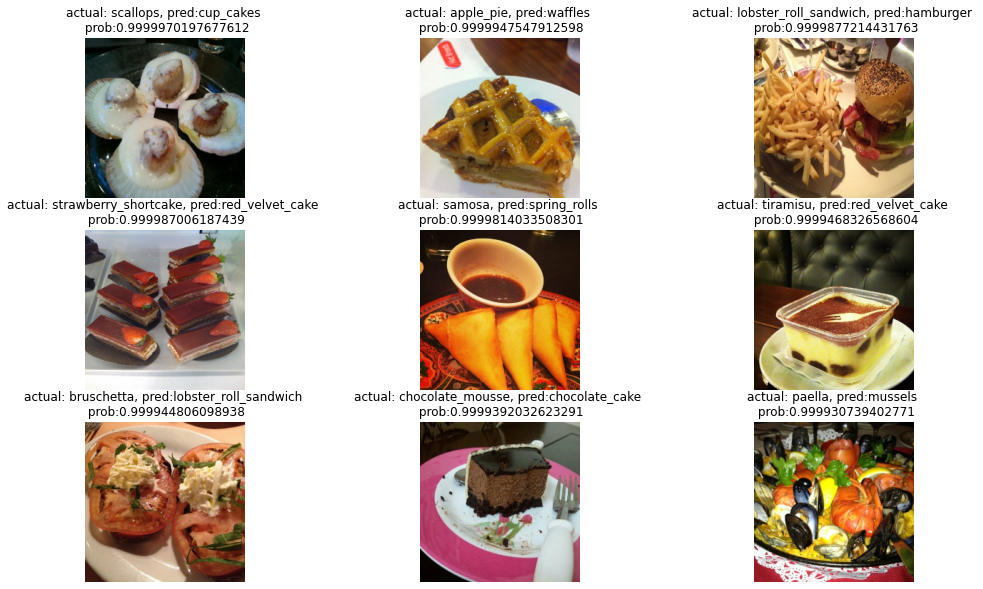

In [182]:
# 5. Visualzie the test data sample which have the wrong predictions but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize = (17, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_images(row[1], scale = False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few params of each row
    plt.imshow(img/255.)
    plt.title(f'actual: {y_true_classname}, pred:{y_pred_classname} \n prob:{pred_prob}')
    plt.axis(False)

## Test out the big model on our own custom images

In [185]:
# Get custom images
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data('custom_food_images.zip')


Saved under custom_food_images.zip


In [186]:
# Get the custom food images filepaths
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

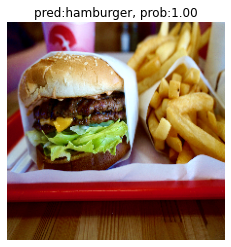

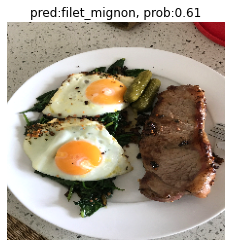

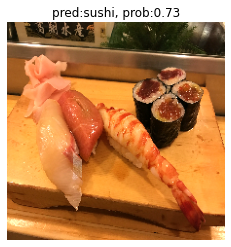

In [188]:
# Make pred on and plot custom food images
for img in custom_food_images:
    img = load_and_prep_images(img, scale = False) # don't need to scale for our EffNetB0
    pred_prob = model.predict(tf.expand_dims(img, axis = 0)) # Make pred on iamge with shape [1, 224, 224, 3] same image is train on
    pred_class = class_names[pred_prob.argmax()] # get the index with highest pred prob
    # Plot the appropiate information
    plt.figure()
    plt.imshow(img/225.)
    plt.title(f'pred:{pred_class}, prob:{pred_prob.max():.2f}')
    plt.axis(False);